In [1]:
import os 
import cv2
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#上传图片展示
import  ipywidgets
import io
from io import BytesIO
from PIL import Image

Make Dataset

In [2]:
class DogsVSCats():
    CATS="PetImages/Cat"
    DOGS="PetImages/Dog"
    LABELS={CATS:0,DOGS:1}
    one_hot_label=np.eye(2)
    training_data=[]
    catcount=0
    dogcount=0
    def __init__(self, img_size=50):
        self.IMG_SIZE=img_size
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            #依次读入文件下的的照片
            for f in tqdm(os.listdir(label)):
                try:
                    path=os.path.join(label,f)  #连接文件路径  PetImages/Cat/*.jpg
                    img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)#灰度图读入
                    img=cv2.resize(img,(self.IMG_SIZE,self.IMG_SIZE))# 重定义size
                    self.training_data.append([np.array(img),
                                               self.one_hot_label[self.LABELS[label]]])
                    
                    if   label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
                    #print(str(e))
            #打标签       
            #print(self.training_data[0])
                    
                    
        np.random.shuffle(self.training_data)
        np.save("training_data.npy",self.training_data)
        print("Cats:",self.catcount)
        print("Dogs:",self.dogcount)    

Build Network

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #nn.Conv2d
        #参数
        #in_channels 
        #out_channels 
        #kernel_size 
        #stride=1 padding=0 dilation=1 groups=1 bias=True padding_model='zeros'
        
        self.conv1=nn.Conv2d(1,32,5)
        #img_size=50
        #(50-kernel_size+2*padding)/strides+1=(50-5+2*0)/1+1=46
        #maxpool 46/2=23
        self.conv2=nn.Conv2d(32,64,5)
        #(23-5+2*0)/1+1=19
        #19/2=9.5->9
        self.conv3=nn.Conv2d(64,128,5)
        #(9-5+2*0)/1+1=5
        #5/2=2.5->2
        self.conv4=nn.Conv2d(64,128,5)
        #50x50x1 
        #--conv2d--> 46x46x32
        #--pool--> 23x23x32 
        #--conv2d--> 19x19x64 
        #--pool--> 9x9x64 
        #--conv2d--> 5x5x128 
        #--pool--> 2x2x128
        #result=2*2*128=512
        
        
        #举例求
        x=torch.randn(50,50).view(-1,1,50,50)
        #在不知道linear的参数的情况下调用convs函数进行求解
        self._to_linear=None
        self.convs(x)
        
        #nn.Linear 扁平化 全连接
        #参数
        #in_features
        #out_features
        #bias=True
        self.fc1=nn.Linear(self._to_linear,512)
        self.fc2=nn.Linear(512,2)
        
    def convs(self,x):
        x=F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x=F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x=F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        
        if self._to_linear is None:
            self._to_linear=x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        #print(self._to_linear)
        return x
    
    #forward propagation    
    def forward(self,x):
        x=self.convs(x)
        x=x.view(-1,self._to_linear)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return F.softmax(x,dim=1)
    

In [25]:
def load_training_data(training_data=None,val_pct=0.1,rebuild_data=False,img_size=50):

    if rebuild_data == True:
        dogsvscats = DogsVSCats(img_size)
        dogsvscats.load_training_data()
    
    if training_data == None:
        training_data = np.load("training_data.npy",allow_pickle=True)
    
    #print(len(training_data))
    #print(training_data[0])
    #print(training_data[1][0])
    plt.title("training_data[1][0]")
    plt.imshow(training_data[1][0],cmap='gray')
    #print(training_data[1][1])
    plt.show()
    
    X=torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
    X=X/255.0
    y=torch.Tensor([i[1] for i in training_data])
    
    val_size=int(len(X)*val_pct)
    #print(val_size)
    
    #data
    train_X=X[:-val_size]
    train_y=y[:-val_size]
    
    test_X=X[-val_size:]
    test_y=y[-val_size:]
    
    #print(len(train_X))
    #print(len(test_X))
    #print(train_X.shape)
    #print(train_y.shape)
    #print(train_X[0])
    #print(train_y[0])
    print("Loading data successed")
    return train_X,train_y,test_X,test_y
def graph_print(x,y):
    fig,ax=plt.subplots(1,1)
    plt.title("Loss Graph")
    ax.plot( x,y,label='trend')
    plt.show()
    
    
def train(net,train_X,train_Y,epochs=100,batch_size=100,Loss=0):
    optimizer=optim.Adam(net.parameters(),lr=0.001)
    loss_function=nn.MSELoss()
    print("Training...")
    time.sleep(1)
    loss_list=[]
    for epoch in range(epochs):
        for i in tqdm(range(0,len(train_X),batch_size),ncols=80):
            batch_X=train_X[i:i+batch_size].view(-1,1,50,50).to(device)
            batch_y=train_y[i:i+batch_size].to(device)
            
            #梯度设为零 连个不同的batch_size不能加梯度
            #但当硬件不行时，可以在n个batch_size运行后=0,变相提高batch_size
            net.zero_grad()
            outputs=net(batch_X)
            loss=loss_function(outputs,batch_y)
            loss.backward()
            optimizer.step()
        print(f"Epoch:{epoch}. Loss:{loss}")
        loss_list.append([epoch,loss])
        time.sleep(1)
        if Loss!=0:
            if loss<=Loss:
                break
        
    print("Training successed")
    graph_print([x[0] for x in loss_list] ,[y[1].item() for y in loss_list])

def test(net,test_X,test_Y):
    time.sleep(1)
    correct=0
    total=0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class=torch.argmax(test_y[i])
            net_out=net(test_X[i].view(-1,1,50,50).to(device))[0]
            predicted_class=torch.argmax(net_out)
            if predicted_class == real_class:
                correct+=1
            total+=1
    print("Accuracy:",round(correct/total,3))

def save_model(net,path='model/CNNP.pth'):
    torch.save(net.state_dict(),path)
    print("Saving model succeed")
    
def load_model(net,path='model/CNNP.pth'):
    net.load_state_dict(torch.load(path))
    #不启用 BatchNormalization 和 Dropout
    net.eval()
    print("Loading model succeed")




running on the GPU
device count:1


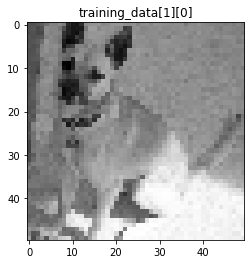

Loading data successed


In [7]:
#checke if it's available for your GPU on the computer
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
    print("device count:"+str(torch.cuda.device_count()))
else:
    device=torch.dcvice("cpu")
    print("running on the CPU")
train_X,train_y,test_X,test_y=load_training_data()

Training...


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 81.98it/s]


Epoch:0. Loss:0.22353844344615936


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 83.00it/s]


Epoch:1. Loss:0.21550697088241577


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 83.25it/s]


Epoch:2. Loss:0.168533593416214


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 83.37it/s]


Epoch:3. Loss:0.12442801892757416


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 82.88it/s]


Epoch:4. Loss:0.09273087978363037


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 88.40it/s]


Epoch:5. Loss:0.07403196394443512


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.20it/s]


Epoch:6. Loss:0.0685209333896637


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 83.28it/s]


Epoch:7. Loss:0.05982455238699913


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 84.31it/s]


Epoch:8. Loss:0.06628662347793579


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 84.27it/s]


Epoch:9. Loss:0.06515047699213028


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 87.75it/s]


Epoch:10. Loss:0.055740389972925186


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 86.97it/s]


Epoch:11. Loss:0.060427479445934296


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 83.93it/s]


Epoch:12. Loss:0.049991901963949203


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 83.68it/s]


Epoch:13. Loss:0.03232533484697342


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 84.31it/s]


Epoch:14. Loss:0.05295189842581749


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 77.53it/s]


Epoch:15. Loss:0.05431414768099785


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 84.62it/s]


Epoch:16. Loss:0.027380958199501038


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 87.71it/s]


Epoch:17. Loss:0.02370908483862877


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.71it/s]


Epoch:18. Loss:0.009147590957581997


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 83.06it/s]


Epoch:19. Loss:0.003457240993157029


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 83.80it/s]


Epoch:20. Loss:0.01699230447411537


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 84.88it/s]


Epoch:21. Loss:0.01023952104151249


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 86.87it/s]


Epoch:22. Loss:6.787620077375323e-05


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 88.59it/s]


Epoch:23. Loss:0.014094860292971134


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.00it/s]


Epoch:24. Loss:0.019461946561932564


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.16it/s]


Epoch:25. Loss:0.018799474462866783


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.39it/s]


Epoch:26. Loss:9.135561413131654e-05


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.23it/s]


Epoch:27. Loss:0.02020239271223545


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 89.07it/s]


Epoch:28. Loss:0.002951789414510131


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 86.57it/s]


Epoch:29. Loss:0.000805956544354558


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.29it/s]


Epoch:30. Loss:5.731916462536901e-05


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.36it/s]


Epoch:31. Loss:0.001381031353957951


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.39it/s]


Epoch:32. Loss:0.00046412594383582473


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 88.89it/s]


Epoch:33. Loss:0.011448650620877743


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 87.17it/s]


Epoch:34. Loss:0.00032795770675875247


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.33it/s]


Epoch:35. Loss:7.721194560872391e-05


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.36it/s]


Epoch:36. Loss:0.00040540244663134217


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.49it/s]


Epoch:37. Loss:0.001127199619077146


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 87.75it/s]


Epoch:38. Loss:0.0011586147593334317


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 88.19it/s]


Epoch:39. Loss:0.014654845930635929


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.36it/s]


Epoch:40. Loss:0.0014265706995502114


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.23it/s]


Epoch:41. Loss:0.002599199302494526


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.20it/s]


Epoch:42. Loss:9.903142927214503e-05


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.99it/s]


Epoch:43. Loss:0.018342314288020134


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.49it/s]


Epoch:44. Loss:0.0003055751440115273


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.04it/s]


Epoch:45. Loss:0.001172587275505066


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 84.65it/s]


Epoch:46. Loss:5.400797090260312e-05


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 81.86it/s]


Epoch:47. Loss:0.0012588213430717587


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 83.77it/s]


Epoch:48. Loss:0.0007766527705825865


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.42it/s]


Epoch:49. Loss:0.0024829432368278503


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 86.40it/s]


Epoch:50. Loss:6.840122296125628e-06


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 90.57it/s]


Epoch:51. Loss:0.001108886324800551


100%|████████████████████████████████████████| 225/225 [00:02<00:00, 109.78it/s]


Epoch:52. Loss:0.00020349178521428257


100%|████████████████████████████████████████| 225/225 [00:02<00:00, 110.21it/s]


Epoch:53. Loss:0.02827870287001133


100%|████████████████████████████████████████| 225/225 [00:02<00:00, 110.43it/s]


Epoch:54. Loss:0.0020596564281731844


100%|████████████████████████████████████████| 225/225 [00:02<00:00, 111.13it/s]


Epoch:55. Loss:0.0008235273417085409


100%|████████████████████████████████████████| 225/225 [00:02<00:00, 108.93it/s]


Epoch:56. Loss:0.022621307522058487


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 93.11it/s]


Epoch:57. Loss:0.0017715602880343795


100%|████████████████████████████████████████| 225/225 [00:02<00:00, 101.26it/s]


Epoch:58. Loss:0.015800992026925087


100%|████████████████████████████████████████| 225/225 [00:02<00:00, 110.32it/s]


Epoch:59. Loss:2.046149347734172e-05


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 92.18it/s]


Epoch:60. Loss:5.429117663879879e-06


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.13it/s]


Epoch:61. Loss:0.000622590712737292


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 84.72it/s]


Epoch:62. Loss:1.606189107405953e-05


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 84.84it/s]


Epoch:63. Loss:0.0017518411623314023


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 84.18it/s]


Epoch:64. Loss:0.00027846256853081286


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 87.51it/s]


Epoch:65. Loss:0.03650948405265808


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 87.99it/s]


Epoch:66. Loss:0.001262863166630268


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 84.09it/s]


Epoch:67. Loss:0.001133152050897479


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 84.97it/s]


Epoch:68. Loss:0.00017880054656416178


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 84.27it/s]


Epoch:69. Loss:0.004334558267146349


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 84.19it/s]


Epoch:70. Loss:1.3906757885706611e-05


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 86.77it/s]


Epoch:71. Loss:0.008158190175890923


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 86.22it/s]


Epoch:72. Loss:0.03546413034200668


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 84.84it/s]


Epoch:73. Loss:5.317115210345946e-05


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.13it/s]


Epoch:74. Loss:2.1849988115718588e-05


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.26it/s]


Epoch:75. Loss:0.00039033169741742313


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.75it/s]


Epoch:76. Loss:4.975589945388492e-06


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 88.99it/s]


Epoch:77. Loss:0.0035231546498835087


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.65it/s]


Epoch:78. Loss:0.0030909450724720955


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 84.59it/s]


Epoch:79. Loss:0.0009185036760754883


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.29it/s]


Epoch:80. Loss:1.991182034544181e-05


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.29it/s]


Epoch:81. Loss:0.00038888072595000267


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 88.99it/s]


Epoch:82. Loss:1.501884798926767e-05


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 86.97it/s]


Epoch:83. Loss:9.878850505629089e-06


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.20it/s]


Epoch:84. Loss:2.8651067623286508e-05


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.29it/s]


Epoch:85. Loss:0.01888703741133213


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.42it/s]


Epoch:86. Loss:4.712371082860045e-05


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 87.82it/s]


Epoch:87. Loss:0.012869181111454964


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 88.16it/s]


Epoch:88. Loss:8.158142918546218e-06


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.16it/s]


Epoch:89. Loss:0.0002258548338431865


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.23it/s]


Epoch:90. Loss:0.0011202991008758545


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.04it/s]


Epoch:91. Loss:0.0006425007595680654


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 86.34it/s]


Epoch:92. Loss:0.01032459456473589


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 83.65it/s]


Epoch:93. Loss:0.0003180781495757401


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 86.40it/s]


Epoch:94. Loss:0.003894651774317026


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.23it/s]


Epoch:95. Loss:3.7356123357312754e-05


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 85.39it/s]


Epoch:96. Loss:2.263807630242809e-08


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 83.90it/s]


Epoch:97. Loss:0.012719649821519852


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 87.41it/s]


Epoch:98. Loss:5.4891275794943795e-05


100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 88.44it/s]


Epoch:99. Loss:0.006337449420243502
Training successed


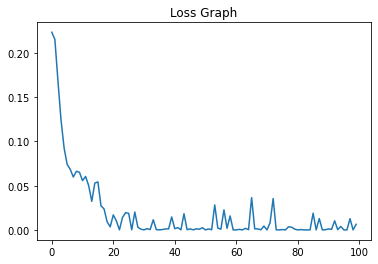

100%|████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:02<00:00, 1080.20it/s]

Accuracy: 0.755


In [26]:
net=Net().to(device)
train(net,train_X,train_y)
test(net,test_X,test_y)

In [19]:
save_model(net)
test(net,test_X,test_y)

Saving model succeed


100%|████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:02<00:00, 1135.64it/s]

Accuracy: 0.724


In [20]:
net=Net().to(device)
load_model(net)
test(net,test_X,test_y)

Loading model succeed


100%|█████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:02<00:00, 902.12it/s]

Accuracy: 0.724


In [11]:
uploader=ipywidgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

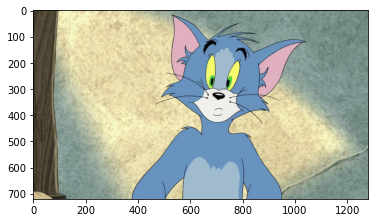

Is it a cat?
No,it's a dog!


In [27]:
bytes_stream = BytesIO(uploader.data[0])
img = Image.open(bytes_stream)
plt.imshow(img)
plt.show()
img = 255 * np.array(img).astype('uint8')
img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
img=cv2.resize(img,(50,50))
y=torch.Tensor(img)
y=y.reshape(-1,1,50,50)
predict_result=net(y.to(device))
predict_result=torch.argmax(predict_result)
#print(predict_result)
print("Is it a cat?")
if predict_result==1:
    print("No,it's a dog!")
elif predict_result==0:
    print("Yes, it's a cat!")